In [54]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

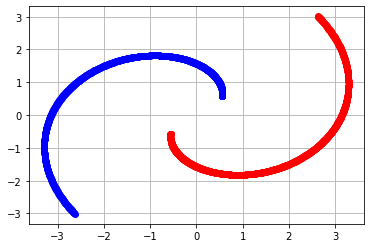

In [55]:
t = np.arange(2, 10, 0.01) * 0.4
blue_spiral = np.array([np.cos(t), np.sin(t)]) * t
plt.grid()
plt.plot(*blue_spiral, "bo")

red_spiral = np.array([np.cos(t + np.pi), np.sin(t + np.pi)]) * t
plt.plot(*red_spiral, "ro")

In [56]:
blue_spiral.shape # (60x2  * 2x2)

(2, 800)

In [57]:
# preparing data for training
labels_blue = np.ones(len(blue_spiral.T)).reshape(-1, 1)
labels_red = np.zeros(len(blue_spiral.T)).reshape(-1, 1)

blue_spiral_l = np.concatenate((blue_spiral.T, labels_blue), axis=1)
red_spiral_l = np.concatenate((red_spiral.T, labels_red), axis=1)

data = np.concatenate((blue_spiral_l, red_spiral_l), axis=0)
data = torch.tensor(data, dtype=torch.float32)

In [58]:
# neural network

class Model(nn.Module):
    def __init__(self) -> None:
        super(Model, self).__init__()

        self.fc1 = nn.Linear(2, 2)
        self.fc2 = nn.Linear(2, 2)
        self.fc3 = nn.Linear(2, 2)
        self.fc4 = nn.Linear(2, 2)
        self.fc5 = nn.Linear(2, 1)

    def forward(self, input):
        outputs = [input]

        x = self.fc1(input)
        outputs.append(x)
        x = torch.tanh(x)
        outputs.append(x)

        x = self.fc2(x)
        outputs.append(x)
        x = torch.tanh(x)
        outputs.append(x)

        x = self.fc3(x)
        outputs.append(x)
        x = torch.tanh(x)
        outputs.append(x)

        x = self.fc4(x)
        outputs.append(x)
        x = torch.tanh(x)
        outputs.append(x)


        return self.fc5(x), outputs

In [59]:
model = Model().float()

optimizer = optim.SGD(model.parameters(), lr=1e-3)
model.requires_grad_(True)

Model(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=2, bias=True)
  (fc5): Linear(in_features=2, out_features=1, bias=True)
)

In [60]:
for i in range(100000):
    x, labels = data[:, 0:2], data[:, 2].unsqueeze(1)
    pred,_ = model(x)
    # pred = torch.sigmoid(pred)
    loss = F.binary_cross_entropy_with_logits(pred, labels)

    if i % 1000 == 0:
        print(f"epoch: {i}, loss: {loss.item():.4f}")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

epoch: 0, loss: 0.7999
epoch: 1000, loss: 0.7213
epoch: 2000, loss: 0.6948
epoch: 3000, loss: 0.6829
epoch: 4000, loss: 0.6726
epoch: 5000, loss: 0.6572
epoch: 6000, loss: 0.6292
epoch: 7000, loss: 0.5757
epoch: 8000, loss: 0.4875
epoch: 9000, loss: 0.3842
epoch: 10000, loss: 0.2970
epoch: 11000, loss: 0.2347
epoch: 12000, loss: 0.1916
epoch: 13000, loss: 0.1613
epoch: 14000, loss: 0.1391
epoch: 15000, loss: 0.1222
epoch: 16000, loss: 0.1088
epoch: 17000, loss: 0.0977
epoch: 18000, loss: 0.0882
epoch: 19000, loss: 0.0798
epoch: 20000, loss: 0.0722
epoch: 21000, loss: 0.0653
epoch: 22000, loss: 0.0591
epoch: 23000, loss: 0.0536
epoch: 24000, loss: 0.0488
epoch: 25000, loss: 0.0446
epoch: 26000, loss: 0.0410
epoch: 27000, loss: 0.0378
epoch: 28000, loss: 0.0351
epoch: 29000, loss: 0.0327
epoch: 30000, loss: 0.0306
epoch: 31000, loss: 0.0287
epoch: 32000, loss: 0.0271
epoch: 33000, loss: 0.0256
epoch: 34000, loss: 0.0243
epoch: 35000, loss: 0.0231
epoch: 36000, loss: 0.0220
epoch: 37000, 

In [63]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.1118, -1.3158],
         [ 0.9703, -0.5846]], requires_grad=True),
 Parameter containing:
 tensor([-0.0758, -0.0109], requires_grad=True),
 Parameter containing:
 tensor([[-0.4607, -1.0789],
         [-0.6621, -1.1857]], requires_grad=True),
 Parameter containing:
 tensor([-0.1626, -0.2111], requires_grad=True),
 Parameter containing:
 tensor([[ 0.2765, -0.1452],
         [-1.2792, -1.6105]], requires_grad=True),
 Parameter containing:
 tensor([ 0.9512, -0.4507], requires_grad=True),
 Parameter containing:
 tensor([[ 0.4591, -1.8305],
         [ 0.4216, -2.0197]], requires_grad=True),
 Parameter containing:
 tensor([-0.3144, -0.3060], requires_grad=True),
 Parameter containing:
 tensor([[2.6350, 2.9175]], requires_grad=True),
 Parameter containing:
 tensor([-0.0686], requires_grad=True)]

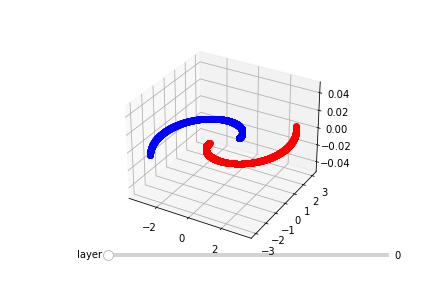

In [62]:
from matplotlib.widgets import Slider
%matplotlib widget

x, labels = data[:, 0:2], data[:, 2].detach().numpy()
_, hidden_out = model(x)

ax_layer = plt.axes([0.25, 0.1, 0.65, 0.03])
layer_slider = Slider(ax_layer, label="layer", valmin=0, valmax=len(hidden_out)-1, valstep=1)

ax = plt.axes(projection="3d")
def update_graph(val):
    ax.clear()
    layer = hidden_out[layer_slider.val].detach().numpy()
    for h_out, label in zip(layer, labels):
        color = "ro" if label == 0 else "bo"
        ax.plot3D(*h_out, color)

update_graph(0)
layer_slider.on_changed(update_graph)

plt.show()